# CFM56-3 Model

#### Notes:
-

#### References:
[1] - Martins, 2015, _Off-Design Performance Prediction of the CFM56-3 Aircraft
Engine_

In [1]:
import gazania as gaz
import cantera as ct
import scipy.optimize
import matplotlib.pyplot as plt
from pprint import pprint

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 130

In [2]:
# Data from page 35 of Ref [1]
thrust = 99.72e3
mdot_f = 1.0951
LCV = 42.769e6

# Compression system
LPC_core = gaz.Compressor(isen = 0.89, PR = 1)
LPC_bypass = gaz.Compressor(isen = 0.9001, PR = 1.655)
IPC = gaz.Compressor(isen = 0.8776, PR = 2.182)
HPC = gaz.Compressor(isen = 0.8677, PR = 11.069)
bleed_out = gaz.BleedOut(mdot_out = 7.45, id = "pre-turbine")

# Combustor
gri30 = ct.Solution('gri30.xml')
fuel = ct.Quantity(gri30, mass = mdot_f)
fuel.TPX = 800, 25e5, "C:14, H:28"

fuel_mixer = gaz.Mixer(fluid = fuel, ignore_T = True, ignore_p = True)  # Mix the fuel in (note gri30 assumes ideal gases)
equilibrium = gaz.Equilibrium(constant = "TP")                          # Equilibrate to get updated properties
heat_in = gaz.HeatExchanger(Qdot = mdot_f * LCV, PR = 0.95)             # Input fuel heat at these new properties

# Turbines
bleed_in_1 = gaz.BleedIn(mdot_in = 3.699, id = "pre-turbine")
HPT = gaz.Turbine(isen = 0.8500, PR = 4.082)
bleed_in_2 = gaz.BleedIn(mdot_in = 3.15, id = "pre-turbine")
LPT = gaz.Turbine(isen = 0.8713, PR = 3.846)
bleed_in_3 = gaz.BleedIn(mdot_in = 0.581, id = "pre-turbine")

# Nozzle
nozzle_bypass = gaz.Nozzle(type = "C")
nozzle_core = gaz.Nozzle(type = "C")

# Set up turbofan
core_components = [LPC_core, 
                   IPC, 
                   HPC, 
                   bleed_out,
                   fuel_mixer,
                   equilibrium,
                   heat_in,
                   equilibrium,
                   bleed_in_1,
                   HPT, 
                   bleed_in_2,
                   LPT, 
                   bleed_in_3,
                   nozzle_core]
    
bypass_components = [LPC_bypass, 
                     nozzle_bypass]

turbofan = gaz.engine.Turbofan(mdot_in = 313.798,
                                BPR = 4.9386,
                                bypass_components = bypass_components,
                                core_components = core_components,
                                p_in = 101325,
                                T_in = 288.15,
                                V_in = 0.0)

turbofan.solve()



----------------COMMENTS----------------
Thrust error = 1.56 %
Power imbalance = -0.9599546590779499 MW 
                = 2.371463378062857 % of turbine power
                = -2.4290678321301282 % of compressor power


----------------TURBOFAN SOLUTION----------------
<gazania.Turbofan object> 
Inlet conditions: 
M = 0.0 
p0 = 101325.00000430821 Pa (p = 101325 Pa)
T0 = 288.15000000350943 K (T = 288.15 Pa)

Power: 
Compressor powers (bypass) = [12997166.680866653] W
Compressor powers (core) = [0.0001843434283918341, 4353672.438306736, 22168627.82925088] W
Turbine powers (core) = [-22723941.10830031, -17755480.49938626] W (negative means net power out)
Net power in = -959954.6590779498 W (positive means insufficent turbine power)

Thrust: 
Core nozzle area = 0.27060856033783115 m2 
Bypass nozzle area = 0.7075901254806614 m2 

Total thrust = 101272.23760410349 N 
Core thrust = 22514.644018159954 N 
Bypass thrust = 78757.59358594353 N


----------------COMBUSTOR INLET COMPONENTS------

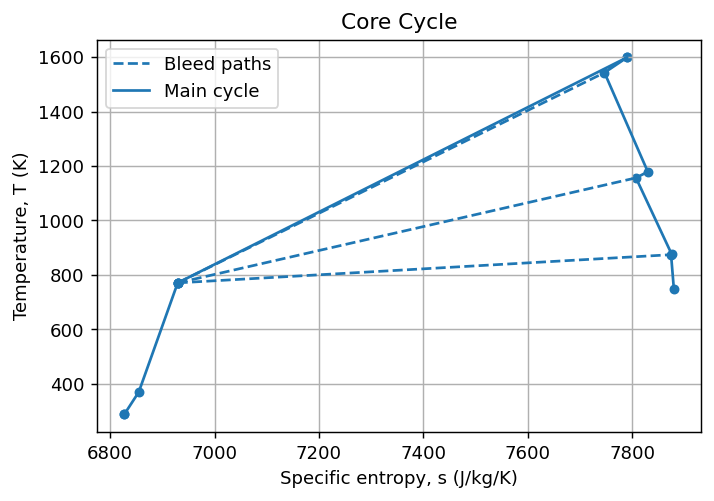

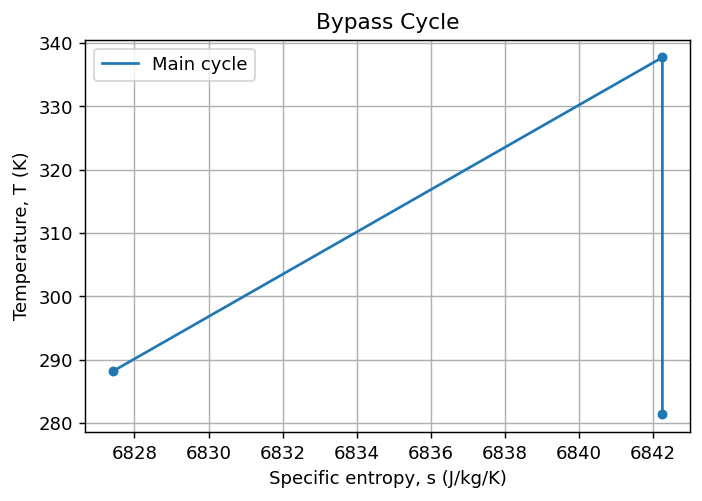

In [3]:
# Print the engine properties and the core cycle
print(f"""\n\n----------------COMMENTS----------------
Thrust error = {(turbofan.thrust - thrust)/thrust * 100:.2f} %
Power imbalance = {turbofan.net_power/1e6} MW 
                = {100 * turbofan.net_power/sum(turbofan.core_turbine_powers)} % of turbine power
                = {100 * turbofan.net_power/(sum(turbofan.core_compressor_powers) + sum(turbofan.bypass_compressor_powers))} % of compressor power""")

print("\n\n----------------TURBOFAN SOLUTION----------------")
print(turbofan)

print("\n\n----------------COMBUSTOR INLET COMPONENTS----------------")
mole_fraction_dict = turbofan.core_cycle.gas[6].mole_fraction_dict()                                      # Get mole fractions
mole_fraction_dict = dict(sorted(mole_fraction_dict.items(), key=lambda item: item[1], reverse = True))   # Order by mole frac
mole_fraction_dict = dict(list(mole_fraction_dict.items())[:10])                                          # Crop to first 10
pprint(mole_fraction_dict, sort_dicts = False)

print("\n\n----------------COMBUSTOR OUTLET COMPONENTS----------------")
mole_fraction_dict = turbofan.core_cycle.gas[8].mole_fraction_dict()                                      
mole_fraction_dict = dict(sorted(mole_fraction_dict.items(), key=lambda item: item[1], reverse = True))   
mole_fraction_dict = dict(list(mole_fraction_dict.items())[:10])                                          
pprint(mole_fraction_dict, sort_dicts = False)

print("\n\n----------------CORE CYCLE SOLUTION----------------")
print(turbofan.core_cycle)

turbofan.core_cycle.plot(axes = "TS")
plt.title("Core Cycle")
plt.savefig("img/core_cycle.svg")
plt.show()

turbofan.bypass_cycle.plot(axes = "TS")
plt.title("Bypass Cycle")
plt.savefig("img/bypass_cycle.svg")
plt.show()